# 0. 라이브러리 import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from transformers import BertTokenizerFast
from transformers import TFBertForSequenceClassification
from transformers import TextClassificationPipeline
from tqdm import tqdm
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices() )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12386389547511276344
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14295826432
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2326973793638231484
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


# 1. 데이터 확인

In [2]:
train_data_path ="~/aiffel/dktc/data/train.csv"
train_data = pd.read_csv(train_data_path)
train_data.head()

,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


In [3]:
common_data_filtered_pos_data_path ="~/aiffel/aiffel/dlthon/AIFFEL_DLthon/개인/연우/filtered_pos_data_class_casual/filtered_pos-tagged_normal.csv"
common_data_filtered_pos_data = pd.read_csv(common_data_filtered_pos_data_path)
common_data_filtered_pos_data.head()

,Filtered Morphs
0,부산/NNP 살/VV 부산/NNP 떠나/VV ㅠㅠ/NNG 부산/NNP 싫/VA 바다...
1,며칠/NNG 전/NNG 생치/NNP 보/VV 오/VV 마블/NNG 영화/NNG 맞/...
2,백신/NNG 접종/NNG 차/NNG 마치/VV 사람/NNG 시/NNG 식당/NNG ...
3,길/NNG 가/VV 선임/NNG 만나/VV 키키/NNG 엥/NNG 만나/VV 키키/...
4,제주도/NNP 여행/NNG 가/VV 이번/NNG 가/VV 되/VV 코스/NNG 짜/...


In [4]:
common_data_filtered_pos_data = common_data_filtered_pos_data.dropna()

common_data_filtered_pos_data['class'] = '일반 대화'

common_data_filtered_pos_data['conversation']=common_data_filtered_pos_data['Filtered Morphs']
common_data_filtered_pos_data = common_data_filtered_pos_data.drop(columns=['Filtered Morphs'])

common_data_filtered_pos_data.head()

,class,conversation
0,일반 대화,부산/NNP 살/VV 부산/NNP 떠나/VV ㅠㅠ/NNG 부산/NNP 싫/VA 바다...
1,일반 대화,며칠/NNG 전/NNG 생치/NNP 보/VV 오/VV 마블/NNG 영화/NNG 맞/...
2,일반 대화,백신/NNG 접종/NNG 차/NNG 마치/VV 사람/NNG 시/NNG 식당/NNG ...
3,일반 대화,길/NNG 가/VV 선임/NNG 만나/VV 키키/NNG 엥/NNG 만나/VV 키키/...
4,일반 대화,제주도/NNP 여행/NNG 가/VV 이번/NNG 가/VV 되/VV 코스/NNG 짜/...


In [5]:
print(len(common_data_filtered_pos_data))

2534


In [6]:
train_data = pd.concat([train_data, common_data_filtered_pos_data[:1000]], ignore_index=True)
train_data = train_data.sample(frac=1).reset_index(drop=True)
train_data.head()

,idx,class,conversation
0,3753.0,직장 내 괴롭힘 대화,오늘 몇시에 왔나\n죄송합니다 제가 늦었습니다 정말 죄송합니다\n뭐 늦을 수도 있지...
1,1873.0,협박 대화,지금 당장 뉴스 기사 내가 불러준 대로 보도 해\n 팩트 체크가 되지 않은 기사는 ...
2,2887.0,기타 괴롭힘 대화,아이스케키 \n야 왜이래 치마를 왜 들어 \n아이 왜 이런긴 너가 너무 예뻐서 그래...
3,3194.0,갈취 대화,엄마 이거 내가 써도 되는거지?\n철수야. 그거 엄마 병원빈데.\n엄마 어디아파? ...
4,3712.0,기타 괴롭힘 대화,야 니네집 시장에서 생선가게 하냐?\n응?. 아니 우리 생선가게 안하는데.\n아 근...


Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   idx           3950 non-null   float64
 1   class         4950 non-null   object 
 2   conversation  4950 non-null   object 
dtypes: float64(1), object(2)
memory usage: 116.1+ KB
None


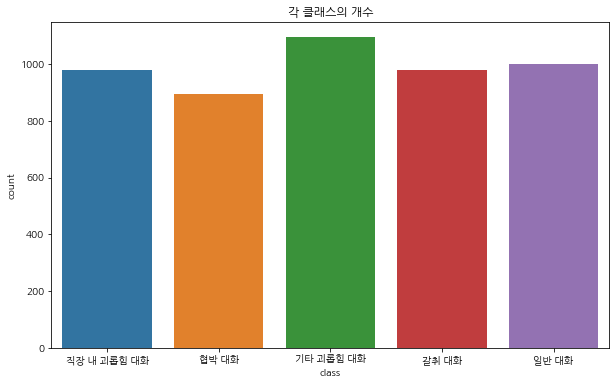

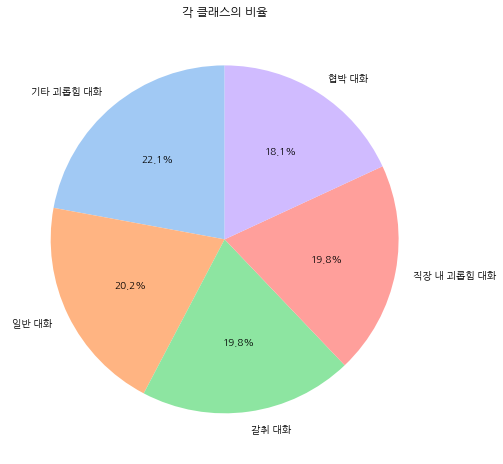

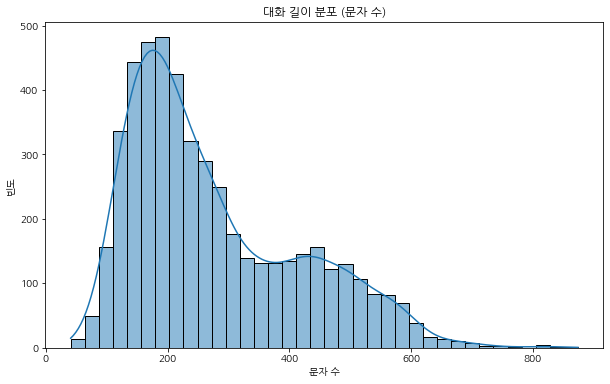

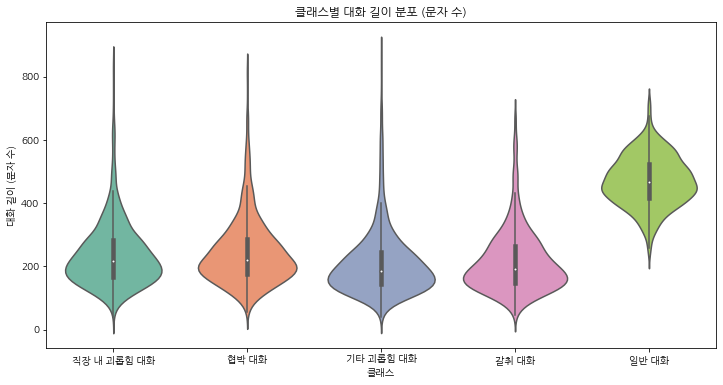

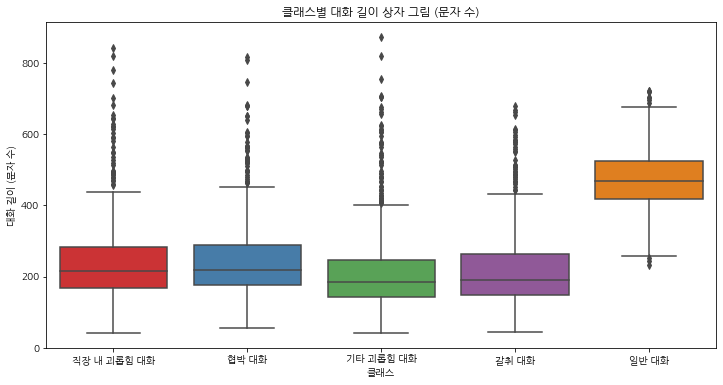

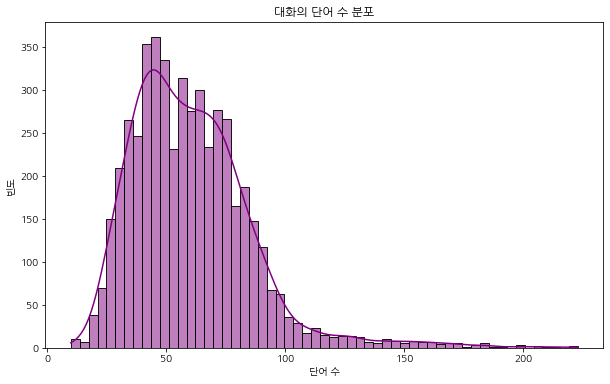

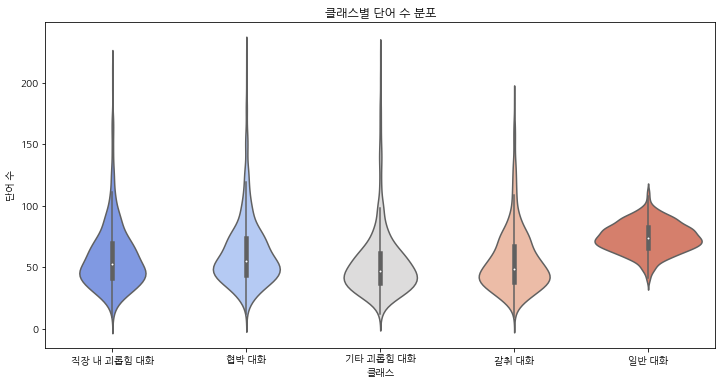

In [7]:
# 한글 폰트 설정 (여기서는 'NanumGothic' 폰트를 사용)
plt.rcParams['font.family'] = 'NanumGothic'

# 데이터 기본 정보 확인
print("Train Data Info:")
print(train_data.info())  # 데이터 타입, 결측치 확인

# 1. 'class' 컬럼의 분포 확인
plt.figure(figsize=(10, 6))
sns.countplot(x='class', data=train_data)
plt.title('각 클래스의 개수')
plt.show()

# 2. 'class' 컬럼의 비율을 Pie Chart로 시각화
plt.figure(figsize=(8, 8))
train_data['class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('각 클래스의 비율')
plt.ylabel('')  # Y-label 제거
plt.show()

# 3. 'conversation' 텍스트의 길이 분포 확인 (각 문장의 문자 수)
train_data['text_length'] = train_data['conversation'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(train_data['text_length'], kde=True)
plt.title('대화 길이 분포 (문자 수)')
plt.xlabel('문자 수')
plt.ylabel('빈도')
plt.show()

# 4. 'class'별로 'conversation' 길이 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='text_length', data=train_data, palette='Set2')
plt.title('클래스별 대화 길이 분포 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 5. 'class'별로 'conversation' 길이 상자 그림(Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='class', y='text_length', data=train_data, palette='Set1')
plt.title('클래스별 대화 길이 상자 그림 (문자 수)')
plt.xlabel('클래스')
plt.ylabel('대화 길이 (문자 수)')
plt.show()

# 6. 'class'별로 대화 내용의 단어 수 분포 확인
train_data['word_count'] = train_data['conversation'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(train_data['word_count'], kde=True, color='purple')
plt.title('대화의 단어 수 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.show()

# 7. 'class'별로 단어 수 분포 확인 (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(x='class', y='word_count', data=train_data, palette='coolwarm')
plt.title('클래스별 단어 수 분포')
plt.xlabel('클래스')
plt.ylabel('단어 수')
plt.show()

In [8]:
train_data.isnull().sum()

idx             1000
class              0
conversation       0
text_length        0
word_count         0
dtype: int64

# 2. 라벨 인코딩 & 데이터 정제

라벨 인코딩

In [9]:
CLASS_NAMES = ['협박 대화', '갈취 대화', '직장 내 괴롭힘 대화', '기타 괴롭힘 대화', '일반 대화']

label_size = len(CLASS_NAMES)

encoder = LabelEncoder()
encoder.fit(CLASS_NAMES)

train_data['class'] = encoder.transform(train_data['class'])
train_data.head()

,idx,class,conversation,text_length,word_count
0,3753.0,3,오늘 몇시에 왔나\n죄송합니다 제가 늦었습니다 정말 죄송합니다\n뭐 늦을 수도 있지...,269,62
1,1873.0,4,지금 당장 뉴스 기사 내가 불러준 대로 보도 해\n 팩트 체크가 되지 않은 기사는 ...,257,72
2,2887.0,1,아이스케키 \n야 왜이래 치마를 왜 들어 \n아이 왜 이런긴 너가 너무 예뻐서 그래...,141,35
3,3194.0,0,엄마 이거 내가 써도 되는거지?\n철수야. 그거 엄마 병원빈데.\n엄마 어디아파? ...,315,81
4,3712.0,1,야 니네집 시장에서 생선가게 하냐?\n응?. 아니 우리 생선가게 안하는데.\n아 근...,235,62


In [10]:
# 데이터 정제 함수
def preprocess_sentence(sentence):

    # 앞뒤 공백 제거
    sentence = sentence.strip()
    # 한글, 영어, 숫자, 구두점 외 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9.,!? ]", " ", sentence)
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # 다중 공백을 단일 공백으로
    sentence = re.sub(r"\s+", " ", sentence)
    
    # ㅋㅋ, ㅎㅎ, ㅠㅠ 등을 정규화
    sentence = re.sub(r'ㅋ{2,}', 'ㅋㅋ', sentence)  # 연속된 ㅋ를 ㅋㅋ로 통일
    sentence = re.sub(r'ㅎ{2,}', 'ㅎㅎ', sentence)  # 연속된 ㅎ를 ㅎㅎ로 통일
    sentence = re.sub(r'ㅠ{2,}', 'ㅠㅠ', sentence)  # 연속된 ㅠ를 ㅠㅠ로 통일

    return sentence

In [11]:
# 데이터 정제
clean_data=[]

for x in train_data['conversation']:
    clean_data.append(preprocess_sentence(x))
    
len(clean_data)

4950

In [12]:
# 정제된 데이터 conversation에 저장
train_data['conversation'] = clean_data

# 3. 데이터셋 분리

In [13]:
# input, target 리스트화
train_texts = train_data['conversation'].to_list() # Features (not-tokenized yet)
train_labels = train_data["class"].to_list() # Labels

In [14]:
x_train, x_test, y_train, y_test = train_test_split(train_texts, train_labels, test_size=0.25, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_test lenght :", len(x_test))
print("y_train lenght :", len(y_train))
print("y_test lenght :", len(y_test))

x_train lenght : 3712
x_test lenght : 1238
y_train lenght : 3712
y_test lenght : 1238


In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=14561)

print("x_train lenght :", len(x_train))
print("x_val lenght :", len(x_val))
print("y_train lenght :", len(y_train))
print("y_val lenght :", len(y_val))

x_train lenght : 2598
x_val lenght : 1114
y_train lenght : 2598
y_val lenght : 1114


# 4. 사전 훈련된 모델의 토크나이저 load

In [16]:
HUGGINGFACE_MODEL_PATH = "klue/bert-base"

klue_bert_tokenizer = BertTokenizerFast.from_pretrained(HUGGINGFACE_MODEL_PATH)

# 5. 토큰화 & 숫자 시퀀스로 변환

In [17]:
# Tokenizing
train_encodings = klue_bert_tokenizer(x_train, truncation=True, padding=True)
val_encodings = klue_bert_tokenizer(x_val, truncation=True, padding=True)
test_encodings = klue_bert_tokenizer(x_test, truncation=True, padding=True)

# 6. 훈련에 사용될 dataset 생성

데이터셋 객체 생성

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_encodings),
        y_train
))

In [19]:
val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_encodings),
        y_val
))

# 7. 사전 훈련된 모델 load

In [20]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true_one_hot = tf.one_hot(y_true, depth=label_size) # shape=(None, 1, 5)
        # 차원 축소하여 (None, 5)로 변경
        y_true_one_hot = tf.squeeze(y_true_one_hot, axis=1)

        
        # 로짓을 소프트맥스로 변환하여 클래스 확률로 변환
        y_pred = tf.nn.softmax(y_pred) # shape=(None, 5)
        
        self.precision.update_state(y_true_one_hot, y_pred, sample_weight)
        self.recall.update_state(y_true_one_hot, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [21]:
num_labels = len(encoder.classes_)
klue_bert_model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, num_labels=num_labels, from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=2.5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
klue_bert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', F1Score()])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Electra 층 동결
klue_bert_model.bert.trainable = False

In [23]:
klue_bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  110617344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  3845      
Total params: 110,621,189
Trainable params: 3,845
Non-trainable params: 110,617,344
_________________________________________________________________


# 8. 모델 훈련

In [24]:
# 학습 데이터셋을 사용해 학습
klue_bert_model.fit(
    train_dataset.shuffle(1000).batch(14), epochs=6,
    validation_data=val_dataset.shuffle(1000).batch(14)
)

Epoch 1/6
186/186 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.8179 - f1_score: 0.8065

/opt/conda/lib/python3.9/site-packages/keras/metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


186/186 [==============================] - 326s 2s/step - loss: 0.5295 - accuracy: 0.8179 - f1_score: 0.8065 - val_loss: 0.2831 - val_accuracy: 0.9138 - val_f1_score: 0.9128
Epoch 2/6
186/186 [==============================] - 310s 2s/step - loss: 0.1851 - accuracy: 0.9450 - f1_score: 0.9438 - val_loss: 0.2838 - val_accuracy: 0.9165 - val_f1_score: 0.9140
Epoch 3/6
186/186 [==============================] - 310s 2s/step - loss: 0.0925 - accuracy: 0.9765 - f1_score: 0.9767 - val_loss: 0.2666 - val_accuracy: 0.9210 - val_f1_score: 0.9225
Epoch 4/6
186/186 [==============================] - 310s 2s/step - loss: 0.0498 - accuracy: 0.9873 - f1_score: 0.9879 - val_loss: 0.2502 - val_accuracy: 0.9309 - val_f1_score: 0.9299
Epoch 5/6
186/186 [==============================] - 310s 2s/step - loss: 0.0344 - accuracy: 0.9919 - f1_score: 0.9921 - val_loss: 0.3055 - val_accuracy: 0.9138 - val_f1_score: 0.9153
Epoch 6/6
186/186 [==============================] - 310s 2s/step - loss: 0.0177 - accurac

# 9. 모델 저장

In [25]:
def save_model(model, tokenizer, MODEL_NAME, MODEL_SAVE_PATH):
    # label을 숫자형태로 encoding 진행함
    # decoding 숫자 -> label 변환
    try:
        
        id2labels = model.config.id2label
        model.config.id2label = {id : encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0]  for id, label in id2labels.items()}

        label2ids = model.config.label2id
        model.config.label2id = {encoder.inverse_transform([int(re.sub('LABEL_', '', label))])[0] : id   for id, label in id2labels.items()}
        
    except Exception as e:
        print("label이 이미 decoding 되있습니다!")

    if os.path.exists(MODEL_SAVE_PATH):
        print(f"{MODEL_SAVE_PATH} -- Folder already exists \n")
    else:
        os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
        print(f"{MODEL_SAVE_PATH} -- Folder create complete \n")

    # save tokenizer, model
    model.save_pretrained(MODEL_SAVE_PATH, save_format='tf')
    tokenizer.save_pretrained(MODEL_SAVE_PATH)
    
MODEL_NAME = "klue-bert-base_filtered_pos_data(common_data)"
MODEL_SAVE_PATH = os.path.join(os.getenv('HOME')+"/aiffel/aiffel/dlthon/", MODEL_NAME) 

save_model(klue_bert_model, klue_bert_tokenizer, MODEL_NAME, MODEL_SAVE_PATH)
klue_bert_model.save_weights("klue_bert_weights.h5")

/aiffel/aiffel/aiffel/dlthon/klue-bert-base_filtered_pos_data(common_data) -- Folder already exists 



# 10. 저장된 모델 load

In [26]:
from transformers import TextClassificationPipeline

# Load Fine-tuning model
loaded_tokenizer = BertTokenizerFast.from_pretrained(MODEL_SAVE_PATH)
loaded_model = TFBertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base_filtered_pos_data(common_data) were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /aiffel/aiffel/aiffel/dlthon/klue-bert-base_filtered_pos_data(common_data).
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for

# 11. 평가

예측

In [27]:
def f1_score_calculation_macro(data, label, text_classifier):
    y_pred = []

    for text in tqdm(data, desc="predictive processing", total=len(data)):
        # predict
        preds_list = text_classifier(text)[0]

        sorted_preds_list = sorted(preds_list, key=lambda x: x['score'], reverse=True)
        preds_list = sorted_preds_list[0] 

        label_value = preds_list['label']
        y_pred.append(label_value)
        
    # label decoding 숫자 -> label 변환
    label = encoder.inverse_transform(label)
    
    # F1 점수 계산
    f1 = f1_score(label, y_pred, average='macro')  # macro는 클래스 크기에 상관없이 모든 클래스를 같은 비중으로 다룸
    
    return f1

f1 = f1_score_calculation_macro(x_test, y_test, text_classifier)
print("F1 Score:", f1)

predictive processing:   1%|▏         | 18/1238 [00:09<11:12,  1.81it/s]


KeyboardInterrupt: 

# 12. 테스트 json 평가

In [28]:
df = pd.read_json('~/aiffel/dktc/data/test.json')

# DataFrame 출력
df

,t_000,t_001,t_002,t_003,t_004,t_005,t_006,t_007,t_008,t_009,...,t_490,t_491,t_492,t_493,t_494,t_495,t_496,t_497,t_498,t_499
text,아가씨 담배한갑주소 네 4500원입니다 어 네 지갑어디갔지 에이 버스에서 잃어버렸나...,우리팀에서 다른팀으로 갈 사람 없나? 그럼 영지씨가 가는건 어때? 네? 제가요? ...,너 오늘 그게 뭐야 네 제가 뭘 잘못했나요.? 제대로 좀 하지 네 똑바로 좀 하지 ...,이거 들어바 와 이 노래 진짜 좋다 그치 요즘 이 것만 들어 진짜 너무 좋다 내가 ...,아무튼 앞으로 니가 내 와이파이야. .응 와이파이 온. 켰어. 반말? 주인님이라고도...,그러니까 빨리 말해. 선생님 제발 살려주십시오. 비밀번호 틀릴 때마다 손톱 하나씩...,그 사람 누구냐? 누구말하는거야? 다 알면서 모른척 하지마. 둘다 쏴버리기 전에...,야 저기야 닭꼬치 트럭왔다 응 그러네 그치? 너도 먹고 싶지? 어?나도? 그래 너 ...,안경 안쓰고 키작고통통해보이는 분이었는데 다안경안씀 쌍꺼풀없었던것같고 아 단발인가...,야 너 2학년 김민석 맞지? 네 맞는데요. 혹시 누구신가요? 내가 누군지 궁금하면 ...,...,철수야 말 들어야지 싫은데 철밥통 선생아 너 선생님한테 말버릇이 뭐야 야 내가 너말...,"양재 터널 입구 앞인데요. 사고가 났거든요? 위치가 양재 터널 맞으시죠? 네, 지금...",동생이쁘다. 나주라 안돼 우리동생건들지마. 왜 안되냐? 좀 달라고 니 목숨값으로 동...,혹시 나 오늘 2만원만 빌려주만 안돼? 응? 안돼. 나도 요즘 맨날 택시타느라 택시...,이봐 네? 누구세요? 입다물고 가진거 다내놔 경찰에 신고할거에요 할 수 있으면 해봐...,미나씨 휴가 결제 올리기 전에 저랑 상의하라고 말한거 기억해요? 네 합니다. 보고서...,교수님 제 논문에 제 이름이 없나요? 아 무슨 논문말이야? 지난 번 냈던 논문이...,야 너 네 저요? 그래 너 왜요 돈좀 줘봐 돈 없어요 돈이 왜 없어 지갑은 폼이...,야 너 빨리 안 뛰어와? 너 이 환자 제대로 봤어 안 봤어 어제 저녁부터 계속 보다...,엄마 저 그 돈 안해주시면 정말 큰일나요. 이유도 말하지 않고. 몇번째니 경민아....


In [29]:
submission_text = df.loc['text'].to_list()

In [32]:
submission_pred = []

for text in tqdm(submission_text, desc="predictive processing", total=len(submission_text)):
    # predict
    preds_list = text_classifier(text)[0]

    sorted_preds_list = sorted(preds_list, key=lambda x: x['score'], reverse=True)
    preds_list = sorted_preds_list[0] 
    
    label_value = preds_list['label']
    submission_pred.append(label_value)

predictive processing: 100%|██████████| 500/500 [03:39<00:00,  2.28it/s]


In [33]:
# 새로운 매핑 정의
label_mapping = {
    "협박 대화": 0,
    "갈취 대화": 1,
    "직장 내 괴롭힘 대화": 2,
    "기타 괴롭힘 대화": 3,
    "일반 대화": 4
}

encoded_labels = [label_mapping[label] for label in submission_pred]

In [34]:
submission = pd.read_csv("~/aiffel/dktc/data/new_submission.csv")
submission['class']=encoded_labels
submission

,file_name,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
...,...,...
495,t_495,2
496,t_496,2
497,t_497,1
498,t_498,0


In [35]:
submission.rename(columns={'file_name': 'idx', 'class': 'target'}, inplace=True)
submission

,idx,target
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,3
4,t_004,3
...,...,...
495,t_495,2
496,t_496,2
497,t_497,1
498,t_498,0


In [36]:
output_file_path = "~/aiffel/aiffel/dlthon/submission.csv"

submission.to_csv(output_file_path, index=False)